# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Config

In [2]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [4]:
df = pd.read_csv("mod_data.csv", index_col="date", parse_dates=True, dtype=np.float32)
df

,close,volume,volume_norm,log_close,log_fit,log_diff,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,,,
2010-07-18,0.100,80.000,-0.674,-2.303,-1.424,-0.878,-0.095,-0.995,-0.266,-0.964
2010-07-19,0.100,570.000,-0.672,-2.303,-1.418,-0.884,-0.297,-0.955,-0.283,-0.959
2010-07-20,0.100,260.000,-0.673,-2.303,-1.412,-0.890,-0.486,-0.874,-0.299,-0.954
2010-07-21,0.100,580.000,-0.672,-2.303,-1.406,-0.896,-0.655,-0.756,-0.316,-0.949
2010-07-22,0.100,"2,160.000",-0.666,-2.303,-1.400,-0.902,-0.796,-0.605,-0.332,-0.943
...,...,...,...,...,...,...,...,...,...,...
2021-11-21,"58,714.301","40,980.000",-0.523,10.980,9.416,1.564,-0.863,-0.505,-0.643,0.766
2021-11-22,"56,308.801","76,450.000",-0.392,10.939,9.416,1.523,-0.948,-0.317,-0.630,0.777
2021-11-23,"57,573.199","72,480.000",-0.406,10.961,9.416,1.545,-0.993,-0.116,-0.616,0.787


In [5]:
df.index.dtype, df.dtypes

(dtype('<M8[ns]'),
 close          float32
 volume         float32
 volume_norm    float32
 log_close      float32
 log_fit        float32
 log_diff       float32
 month_sin      float32
 month_cos      float32
 year_sin       float32
 year_cos       float32
 dtype: object)

In [6]:
log_fit_coef = np.array([[ 9.41599146e+00], [-5.06317303e-08]], dtype=np.float64)

## Train/Test

In [7]:
# input: past 3 weeks
Tx = 21
# output: next 1 week
Ty = 7
# number of features
features = ["volume_norm", "log_diff", "month_sin", "month_cos", "year_sin", "year_cos"]
n = len(features)
# size of train/test data
m = df.shape[0] - (Tx + Ty)

In [8]:
X = np.zeros((m, Tx, n))
y = np.zeros((m, Ty))

for i in range(m):
    X[i, :, :] = df[features].iloc[i:i+Tx].values
    y[i, :] = df["log_diff"].iloc[i+Tx: i+Tx+Ty].values

X = X.astype(np.float32)
y = y.astype(np.float32)

X.shape, X.dtype, y.shape, y.dtype

((4121, 21, 6), dtype('float32'), (4121, 7), dtype('float32'))

In [9]:
batch_size = 32
train_size = int(X.shape[0] * 0.9)

In [10]:
X_train = X[:train_size, :, :]
y_train = y[:train_size, :]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

X_test = X[train_size:, :, :]
y_test = y[train_size:, :]
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print(train_dataset)

print("X_test", X_test.shape)
print("y_test", y_test.shape)
print(test_dataset)

X_train (3708, 21, 6)
y_train (3708, 7)
<BatchDataset shapes: ((None, 21, 6), (None, 7)), types: (tf.float32, tf.float32)>
X_test (413, 21, 6)
y_test (413, 7)
<BatchDataset shapes: ((None, 21, 6), (None, 7)), types: (tf.float32, tf.float32)>


# Model

In [11]:
def create_model(Tx, n, Ty, learning_rate=0.015, decay=0.0075):
    X_in = layers.Input(shape=(Tx, n))
    X = layers.LSTM(42, activation="relu", return_sequences=False)(X_in)
    X_out = layers.Dense(7, activation="relu")(X)

    model = tf.keras.Model(inputs=X_in, outputs=X_out)
    # , decay=decay
    opt = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])

    return model

In [12]:
model = create_model(Tx, n, Ty, learning_rate=0.02, decay=0.005)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 42)                8232      
                                                                 
 dense (Dense)               (None, 7)                 301       
                                                                 
Total params: 8,533
Trainable params: 8,533
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20)

Epoch 1/20
116/116 [==============================] - 6s 45ms/step - loss: 0.7230 - mean_squared_error: 0.7230 - val_loss: 1.4624 - val_mean_squared_error: 1.4624
Epoch 2/20
116/116 [==============================] - 5s 43ms/step - loss: 0.7179 - mean_squared_error: 0.7179 - val_loss: 1.4624 - val_mean_squared_error: 1.4624
Epoch 3/20
116/116 [==============================] - 5s 45ms/step - loss: 0.7179 - mean_squared_error: 0.7179 - val_loss: 1.4624 - val_mean_squared_error: 1.4624
Epoch 4/20
116/116 [==============================] - 6s 48ms/step - loss: 0.7179 - mean_squared_error: 0.7179 - val_loss: 1.4624 - val_mean_squared_error: 1.4624
Epoch 5/20
116/116 [==============================] - 6s 49ms/step - loss: 0.7179 - mean_squared_error: 0.7179 - val_loss: 1.4624 - val_mean_squared_error: 1.4624
Epoch 6/20
116/116 [==============================] - 6s 49ms/step - loss: 0.7179 - mean_squared_error: 0.7179 - val_loss: 1.4624 - val_mean_squared_error: 1.4624
Epoch 7/20
116/116 [==

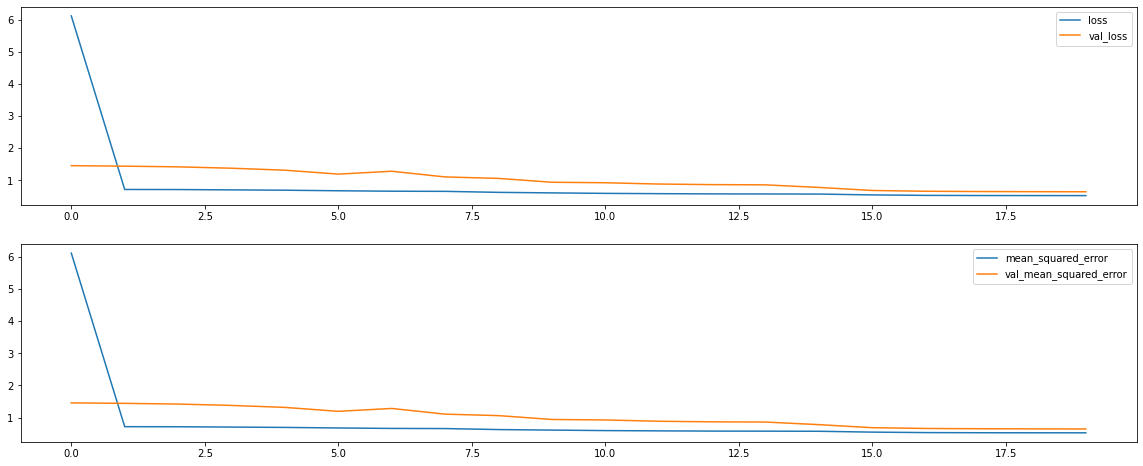

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(history.history["loss"], label="loss")
axes[0].plot(history.history["val_loss"], label="val_loss")
axes[0].legend()
axes[1].plot(history.history["mean_squared_error"], label="mean_squared_error")
axes[1].plot(history.history["val_mean_squared_error"], label="val_mean_squared_error")
axes[1].legend()
plt.show()

In [ ]:
model.save("saved_model/v1.h5")

In [ ]:
model.predict(X[-1:])[0]

array([1.5524166, 0.       , 0.       , 0.       , 1.5781425, 1.6518232,
       1.690831 ], dtype=float32)

In [ ]:
y[-1, :]

array([1.5340364, 1.553648 , 1.5813938, 1.5644488, 1.522616 , 1.5448217,
       1.5378233], dtype=float32)

In [ ]:
X[0,0]

array([-0.6736295 , -0.87817454, -0.0948809 , -0.99548864, -0.26645967,
       -0.9638461 ], dtype=float32)

In [ ]:
y = y[]
for i in range(0, m, 7):
    plt.plot(list(range(i,i+7)), y[i, :], label="true")
    plt.plot(list(range(i,i+7)), model.predict(X[i:])[0], label="predicted")
plt.legend()
plt.show() 

SyntaxError: invalid syntax (Temp/ipykernel_3060/263034176.py, line 1)

In [ ]:
X

array([[[-0.6736295 , -0.87817454, -0.0948809 , -0.99548864,
         -0.26645967, -0.9638461 ],
        [-0.67182136, -0.8841897 , -0.29691198, -0.95490485,
         -0.28300026, -0.95911986],
        [-0.67296535, -0.890203  , -0.4863351 , -0.8737724 ,
         -0.2994571 , -0.9541098 ],
        ...,
        [-0.65536326, -0.98615915,  0.6203831 ,  0.78429896,
         -0.5474952 , -0.8368088 ],
        [-0.6687585 , -0.99214035,  0.7679692 ,  0.6404868 ,
         -0.56180894, -0.82726705],
        [-0.6642566 , -0.99811965,  0.8829446 ,  0.46947727,
         -0.5759564 , -0.81748044]],

       [[-0.67182136, -0.8841897 , -0.29691198, -0.95490485,
         -0.28300026, -0.95911986],
        [-0.67296535, -0.890203  , -0.4863351 , -0.8737724 ,
         -0.2994571 , -0.9541098 ],
        [-0.67178446, -0.8962144 , -0.65510666, -0.7555364 ,
         -0.3158253 , -0.9488174 ],
        ...,
        [-0.6687585 , -0.99214035,  0.7679692 ,  0.6404868 ,
         -0.56180894, -0.82726705],
  